In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from sklearn.preprocessing import StandardScaler

import plotly.express as px


In [3]:
df = pd.read_csv("data_path")
df= df.drop(columns=["None"])
df

,mdate,open_d,high_d,low_d,close_d,volume
0,2020-01-02,332.5,339.0,332.5,339.0,33282.120
1,2020-01-03,344.0,345.0,335.5,339.5,42023.268
2,2020-01-06,333.0,334.5,332.0,332.0,45677.057
3,2020-01-07,332.5,333.0,326.5,329.5,51746.181
4,2020-01-08,325.0,333.0,325.0,329.5,37913.748
...,...,...,...,...,...,...
730,2022-12-26,454.0,457.0,453.5,456.5,9152.790
731,2022-12-27,458.0,462.5,457.0,457.0,10486.219
732,2022-12-28,451.0,452.0,446.0,451.0,34823.492
733,2022-12-29,444.0,449.5,442.5,446.0,25596.357


## LSTM

<ipython-input-4-5b03fecedc8a>:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  return torch.tensor(X), torch.tensor(y).view(-1, 1)


torch.Size([487, 5, 4]) torch.Size([487, 1])
torch.Size([238, 5, 4]) torch.Size([238, 1])
Epoch 0: train_loss 1.2361, val_loss 0.8251
Epoch 100: train_loss 0.1552, val_loss 0.0242
Epoch 200: train_loss 0.1046, val_loss 0.0221
Epoch 300: train_loss 0.0975, val_loss 0.0235
Epoch 400: train_loss 0.0493, val_loss 0.0354
Epoch 500: train_loss 0.0392, val_loss 0.0289
Epoch 600: train_loss 0.0271, val_loss 0.0263
Epoch 700: train_loss 0.0185, val_loss 0.0253
Epoch 800: train_loss 0.0145, val_loss 0.0193
Epoch 900: train_loss 0.0187, val_loss 0.0221


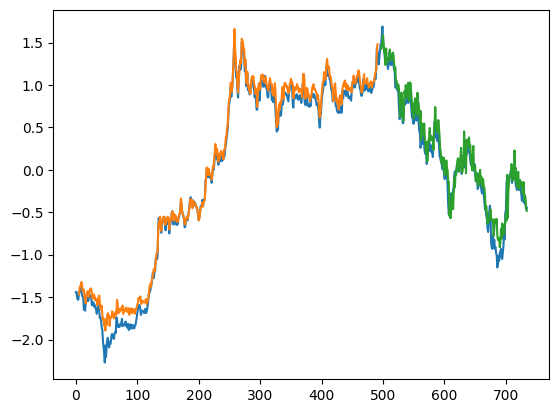

In [4]:
timeseries = df[["open_d", "high_d", "low_d","close_d"]].values.astype('float32')

# 只使用收盤價作為input
# timeseries = df[["close_d"]].values.astype('float32')

# 一定要先將資料標準化，不然loss值會過大導致無法收斂，且預測值全部變成同一個數
# scaler
scaler = StandardScaler()
timeseries = scaler.fit_transform(timeseries)

# train-val split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, val = timeseries[:train_size], timeseries[train_size:]

 
def create_dataset(dataset, lookback):

    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback, :]
        target = dataset[i+1:i+lookback+1][-1][-1]

        # 只使用收盤價作為input
        # feature = dataset[i:i+lookback]
        # target = dataset[i+1:i+lookback+1][-1]

        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y).view(-1, 1)

lookback = 5
X_train, y_train = create_dataset(train, lookback=lookback)
X_val, y_val = create_dataset(val, lookback=lookback)
print(X_train.size(), y_train.size())
print(X_val.size(), y_val.size())

input_size = timeseries.shape[-1]

class LSTM_Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size = input_size, hidden_size=64, num_layers=2, batch_first = True)
        self.linear = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.dropout(x)
        x = x[:, -1, :]
        x = self.linear(x)
        return x

model = LSTM_Model()
# optimizer = optim.Adam(model.parameters())
# 使用SDG或Adam演算法的lstm經常會用RMSprop做為優化方向，因為，它收斂的速度會比較快，原因是RMSprop 的學習速率(learning rate)會隨著之前的梯度總和作反向的調整。
optimizer = optim.RMSprop(model.parameters())
loss_fn = nn.MSELoss()
n_epochs = 1000

loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=False, batch_size=8)
train_loss_array = []
val_loss_array = []

for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # 確認loss值的變化正常
    # if epoch % 100 ==0:
    #     print(y_pred)

    # Validation
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        # train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        train_loss = loss_fn(y_pred, y_train).item()

        y_pred = model(X_val)
        # test_rmse = np.sqrt(loss_fn(y_pred, y_test))
        val_loss = loss_fn(y_pred, y_val).item()

        train_loss_array.append(train_loss)
        val_loss_array.append(val_loss)

    if epoch % 100 == 0:
        print("Epoch %d: train_loss %.4f, val_loss %.4f" % (epoch, train_loss, val_loss))
 
with torch.no_grad():
    model.eval()
    # shift train predictions for plotting
    # 因為timeseries包含開、高、低、收等資料，因此需要timeseries[:, -1]取得最後一項 收盤價 的欄位長度即可
    train_plot = np.ones_like(timeseries[:, -1]) * np.nan
    y_pred = model(X_train)
    # train_plot.shape == (len(X_train), )為一維矩陣，model(X_train).size == (len(X_train), 1)為二維矩陣，因此需要view()
    train_plot[lookback:train_size] = model(X_train).view(-1)

    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries[:,-1]) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_val).view(-1)

# plot
# 因為timeseries包含開、高、低、收等資料，因此需要timeseries[:, -1]取得最後一項 收盤價 的欄位資料即可
plt.plot(timeseries[:, -1])
plt.plot(train_plot)
plt.plot(test_plot)
plt.show()

收盤價預測繪圖

## **測試集**

In [7]:
df_test = pd.read_csv("/content/drive/MyDrive/LSTM/2330_test.csv")
# df= df.drop(columns=["None"])
# test_data = df_test[["close_d"]].values.astype("float32")
test_data = df_test[["open_d", "high_d", "low_d","close_d"]].values.astype('float32')

In [8]:
test_data = scaler.transform(test_data)
x, y  = create_dataset(test_data, lookback=5)
pred = model(x)


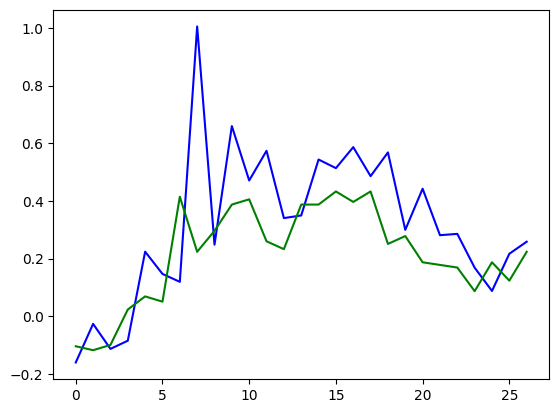

In [9]:
plt.plot(pred.detach().numpy(), c = "b")
plt.plot(y.detach().numpy(), c = "g")
plt.show()